Copyright (c) 2019 [윤기태]

https://github.com/yoonkt200/python-data-analysis

[MIT License](https://github.com/yoonkt200/python-data-analysis/blob/master/LICENSE.txt)

# (가제) 파이썬 데이터 분석

-----

# 5.1) 중고나라 핸드폰 거래가격 예측하기

### 바로가기

- [<Step1. 탐색적 분석> : 중고나라 데이터 분석](#<Step1.-탐색적-분석>-:-중고나라-데이터-분석)
    - [중고나라 데이터셋 살펴보기]
    - [개별 피처 탐색하기]
    - [Random forest regressor를 이용한 가격 예측]
- [<Step2. 피처 엔지니어링> : 예측 모델 개선을 위한 노력](#<Step2.-감성-분석>-:-예측-모델-개선을-위한-노력)
    - [감성 분석을 통한 상품 상태 결정]
- [<Step3. 예측> : 중고폰 거래가 예측](#<Step3.-예측>-:-중고폰-거래가-예측)
    - ㅇㅁㅇㅁ
- [<Step4. 프로토타입> : 얼마고(Almhago?)](#<Step4.-프로토타입>-:-얼마고(Almhago?))
    - ㅇㅁㅇㅁ

-----

In [169]:
# -*- coding: utf-8 -*-

%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

# <Step1. 탐색> : 중고나라 데이터 분석

### [중고나라 데이터셋 살펴보기]

In [170]:
df = pd.read_csv("../data/used_mobile_phone.csv")
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4951 entries, 0 to 4950
Data columns (total 7 columns):
create_date      4951 non-null object
price            4951 non-null float64
text             4951 non-null object
phone_model      4951 non-null object
factory_price    4951 non-null int64
maker            4951 non-null object
price_index      4951 non-null float64
dtypes: float64(2), int64(1), object(4)
memory usage: 270.8+ KB
None


,create_date,price,text,phone_model,factory_price,maker,price_index
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59


-----

### [개별 피처 탐색하기]

##### [date 피처 탐색]

In [171]:
df['month'] = df['create_date'].apply(lambda x: x[:7])
df['month'].value_counts()

2016-10    2956
2017-03    1311
2016-08     107
2016-09     105
2016-04     102
2016-05      89
2016-06      76
2016-07      74
2016-03      70
2016-02      61
Name: month, dtype: int64

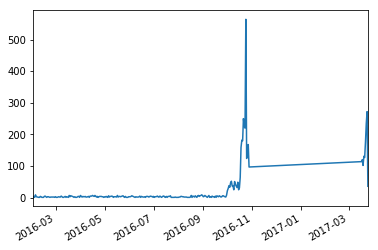

In [172]:
df_day = pd.to_datetime(df['create_date'].apply(lambda x: x[:10])).value_counts()
df_day.plot()
plt.show()

-----

##### [가격 피처 탐색]

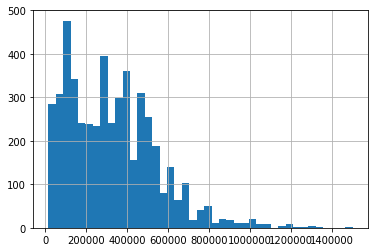

In [173]:
df['price'].hist(bins="auto")

In [174]:
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))

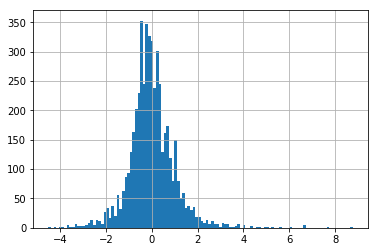

In [175]:
df_price_model_mean = df.groupby('phone_model')['price'].transform(lambda x: np.mean(x))
df_price_model_std = df.groupby('phone_model')['price'].transform(lambda x: np.std(x))
df_price_model_z_score = (df['price'] - df_price_model_mean) / df_price_model_std
df_price_model_z_score.hist(bins="auto")

-----

##### [출고가 피처 탐색]

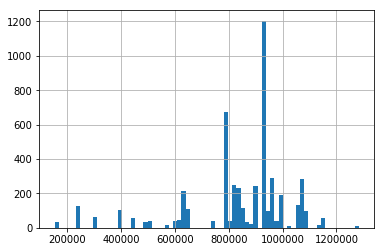

In [176]:
df['factory_price'].hist(bins="auto")

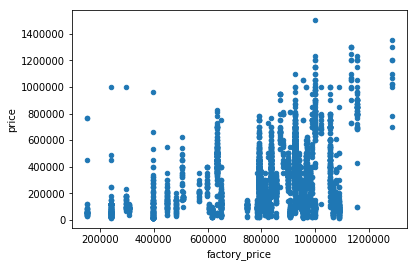

In [177]:
df.plot.scatter(x='factory_price', y='price')

-----

##### [핸드폰 모델 피처 탐색]

count      64.000000
mean       77.359375
std       143.432786
min        10.000000
25%        23.000000
50%        35.000000
75%        90.500000
max      1002.000000
Name: phone_model, dtype: float64


{'whiskers': [<matplotlib.lines.Line2D at 0x12f627c50>,
 'caps': [<matplotlib.lines.Line2D at 0x12f63d320>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f627828>],
 'medians': [<matplotlib.lines.Line2D at 0x12f63d9b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f63dcf8>],
 'means': []}

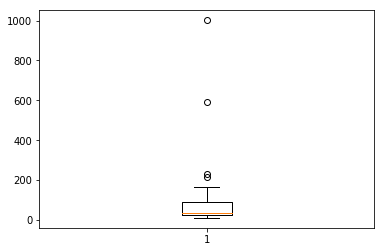

In [178]:
model_counts = df['phone_model'].value_counts()
print(model_counts.describe())
plt.boxplot(model_counts)

-----

##### [메이커 피처 탐색]

apple      2450
samsung    1642
lg          677
pantech      57
sony         37
huawei       35
tg           28
sky          25
Name: maker, dtype: int64


{'whiskers': [<matplotlib.lines.Line2D at 0x12f56d320>,
 'caps': [<matplotlib.lines.Line2D at 0x12f56d9b0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12f414eb8>],
 'medians': [<matplotlib.lines.Line2D at 0x12f56ddd8>],
 'fliers': [<matplotlib.lines.Line2D at 0x12f57a3c8>],
 'means': []}

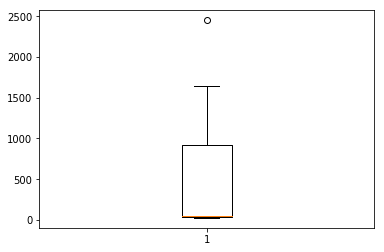

In [179]:
maker_counts = df['maker'].value_counts()
print(maker_counts)
plt.boxplot(maker_counts)

-----

##### [물가 피처 탐색]

In [180]:
df['price_index'].value_counts()

103.05    3061
95.96     1311
102.59     448
94.90      131
Name: price_index, dtype: int64

-----

### [Random forest regressor를 이용한 가격 예측]

In [137]:
df.head()

,create_date,price,text,phone_model,factory_price,maker,price_index,month
0,2017-03-19 4 35 00 PM,550000.0,아이폰6플러스 블랙+애플라이트 64기가 팝니다 아이폰6플러스 블랙+애플라이트 64...,iphone 6 64gb,924000,apple,95.96,2017-03
1,2016-10-26 12 08 00 PM,380000.0,갤럭시s6엣지 32기가 팝니다 직거래 갤럭시s6엣지 32기가 품명 갤럭시s6엣지제...,galaxy s6 edge 32gb,979000,samsung,103.05,2016-10
2,2016-10-25 12 52 00 PM,300000.0,갤럭시s6 풀박스로 팝니다~~~ 새상품급 실기스조차 없어요 직접거래 구매한지 1...,galaxy s6 32gb,854000,samsung,103.05,2016-10
3,2017-03-23 11 14 00 PM,290000.0,sk g5 티탄 폰 단품판매합니다 직접거래 sk g5 티탄 폰 단품판매합니다 올...,lg g5 32gb,836000,lg,95.96,2017-03
4,2016-04-11 7 35 00 PM,280000.0,sony 엑스페리아 c5 ultra e5506 16gb 미사용 새제품 팝니다 1...,lg u 32gb,396000,lg,102.59,2016-04


-----

##### [Random forest 모델 학습]

MSE train: 10622043183.798, test: 13892446640.296
R^2 train: 0.781, test: 0.682


[('factory_price', 0.4058917215936628),
 ('maker_apple', 0.2973586958535099),
 ('phone_model_galaxy s3 3g 8gb', 0.022255858514105248),
 ('phone_model_iphone se 64gb', 0.02137372689908231),
 ('price_index', 0.020758521399460668),
 ('phone_model_galaxy s4 32gb', 0.01720948643057772),
 ('month_2017-03', 0.014956706742522117),
 ('maker_samsung', 0.014760585747394774),
 ('phone_model_galaxy s6 32gb', 0.01248010912474373),
 ('month_2016-05', 0.010881736299071305)]

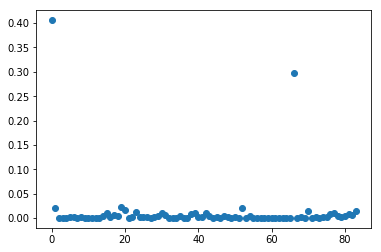

In [164]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 학습용 데이터 준비
df = df[['price', 'phone_model', 'factory_price', 'maker', 'price_index', 'month']]
df = pd.get_dummies(df, columns=['phone_model', 'maker', 'month'])
X = df.loc[:, df.columns != 'price']
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# 랜덤 포레스트 학습 및 평가
forest = RandomForestRegressor(n_estimators=1000,
                               criterion='mse')
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)
print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

# 피처 중요도 plot
importances = forest.feature_importances_
plt.plot(importances, "o")

# 피처 중요도 print
feat_labels = X.columns.tolist()
feature = list(zip(feat_labels, forest.feature_importances_))
sorted(feature, key=lambda tup: tup[1], reverse=True)[:10]

-----

##### [예측 결과 scatter plot]

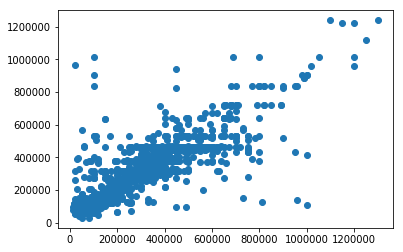

In [168]:
plt.scatter(y_test.values, y_test_pred)

In [139]:
# date diff normalize
# price mean, std
# price quantile -> 감성분류 점수
# split model by two : model without storage, storage
# factori_price quantile by model
# factori price ~ price : drop rate